## Data Processing ##

In [1]:
# Setup pandas display attributes
import pandas as pd

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 20)

In [2]:
# Load data
df = pd.read_csv('mental_health_sentiment.csv', index_col=0)
# Rename text and label columns to be generic
df.rename(columns={"statement": "text", "status": "label"}, inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    52681 non-null  object
 1   label   53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


,text,label
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless heart. All out of tune",Anxiety
2,"All wrong, back off dear, forward doubt. Stay in a restless and restless place",Anxiety
3,I've shifted my focus to something else but I'm still worried,Anxiety
4,"I'm restless and restless, it's been a month now, boy. What do you mean?",Anxiety


In [3]:
# Statistical features
df["label"].value_counts()

,count
label,
Normal,16351
Depression,15404
Suicidal,10653
Anxiety,3888
Bipolar,2877
Stress,2669
Personality disorder,1201


In [4]:
# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", '', text)              # remove punctuation and numbers
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Encode Sentiment Labels
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['label_encoded'] = encoder.fit_transform(df['label'])

# Print encoding map for reference
label_map = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(label_map)

{'Anxiety': np.int64(0), 'Bipolar': np.int64(1), 'Depression': np.int64(2), 'Normal': np.int64(3), 'Personality disorder': np.int64(4), 'Stress': np.int64(5), 'Suicidal': np.int64(6)}


In [6]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label_encoded']

# 80-20 stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
# Text Vectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [8]:
# Filter out empty sequences
non_empty_train = X_train_pad.sum(axis=1) > 0
X_train_pad = X_train_pad[non_empty_train]
y_train = y_train[non_empty_train]

non_empty_test = X_test_pad.sum(axis=1) > 0
X_test_pad = X_test_pad[non_empty_test]
y_test = y_test[non_empty_test]

## TF-IDF + Logistic Regression ##

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       778
           1       0.84      0.69      0.76       575
           2       0.71      0.74      0.72      3081
           3       0.83      0.96      0.89      3250
           4       0.65      0.51      0.57       240
           5       0.67      0.42      0.51       534
           6       0.69      0.63      0.66      2131

    accuracy                           0.76     10589
   macro avg       0.74      0.67      0.70     10589
weighted avg       0.75      0.76      0.75     10589



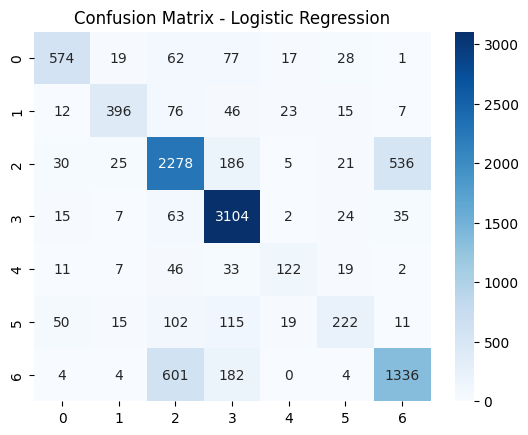

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

non_empty_text = X_train.str.strip().astype(bool)
X_train = X_train[non_empty_text]
y_train = y_train[non_empty_text]

non_empty_text_test = X_test.str.strip().astype(bool)
X_test = X_test[non_empty_text_test]
y_test = y_test[non_empty_text_test]

# TF-IDF feature extraction
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
logreg_preds = logreg_model.predict(X_test_tfidf)
print("Logistic Regression Report:")
print(classification_report(y_test, logreg_preds))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, logreg_preds), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## TF-IDF + SVM ##

SVM Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       778
           1       0.82      0.74      0.78       575
           2       0.70      0.71      0.70      3081
           3       0.85      0.94      0.90      3250
           4       0.65      0.64      0.64       240
           5       0.64      0.46      0.54       534
           6       0.65      0.62      0.64      2131

    accuracy                           0.75     10589
   macro avg       0.73      0.70      0.71     10589
weighted avg       0.75      0.75      0.75     10589



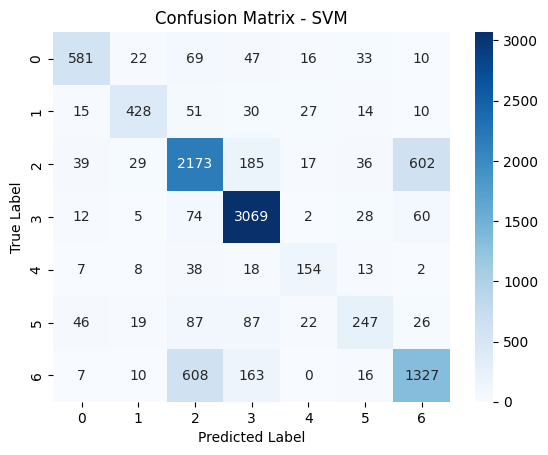

In [10]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train SVM using the same TF-IDF features
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
svm_preds = svm_model.predict(X_test_tfidf)
print("SVM Report:")
print(classification_report(y_test, svm_preds))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## Transformer-Based (BERT fine-tuning) ##

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/42320 [00:00<?, ? examples/s]

Map:   0%|          | 0/10589 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.913500
1000,0.677300
1500,0.603200
2000,0.587800
2500,0.558800
3000,0.470400
3500,0.425800
4000,0.424200
4500,0.398400
5000,0.397400


BERT Evaluation: {'eval_loss': 0.49907729029655457, 'eval_accuracy': 0.8085749362546039, 'eval_f1': 0.7776331132432949, 'eval_runtime': 80.1092, 'eval_samples_per_second': 132.182, 'eval_steps_per_second': 8.264, 'epoch': 2.0}


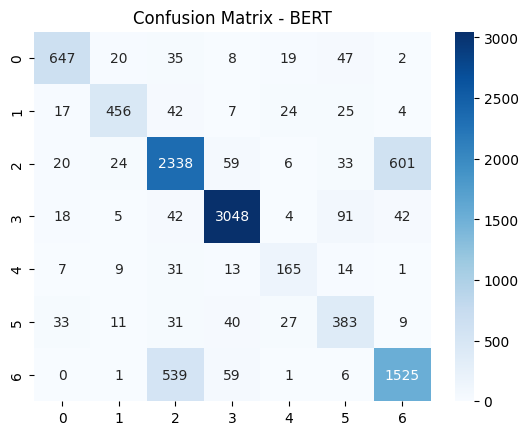

In [11]:
!pip install -U numpy datasets
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate
import numpy as np

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)


# Convert train/test to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train.tolist(), 'label': y_train.tolist()}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test.tolist(), 'label': y_test.tolist()}))

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load BERT model
num_labels = len(set(y_train))
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Define training args
training_args = TrainingArguments(
    output_dir="./bert_output",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    logging_dir="./logs",
    save_strategy="epoch",
    report_to="none"
)

# Evaluation metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
        "f1": f1.compute(predictions=predictions, references=labels, average='macro')["f1"]
    }

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train and evaluate
trainer.train()
results = trainer.evaluate()
print("BERT Evaluation:", results)

# Confusion matrix
bert_preds = np.argmax(trainer.predict(test_dataset).predictions, axis=1)
sns.heatmap(confusion_matrix(y_test, bert_preds), annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - BERT")
plt.show()

In [14]:
print("BERT Classification Report:\n")
print(classification_report(y_test, bert_preds, digits=4))

BERT Classification Report:

              precision    recall  f1-score   support

           0     0.8720    0.8316    0.8513       778
           1     0.8669    0.7930    0.8283       575
           2     0.7646    0.7588    0.7617      3081
           3     0.9425    0.9378    0.9402      3250
           4     0.6707    0.6875    0.6790       240
           5     0.6394    0.7172    0.6761       534
           6     0.6983    0.7156    0.7068      2131

    accuracy                         0.8086     10589
   macro avg     0.7792    0.7774    0.7776     10589
weighted avg     0.8108    0.8086    0.8094     10589

